# Fetch the data of friends from the API Key




In [ ]:
#This is the code to fetch the data of the friends from the api key of lastfm
#-------------------------------------------------------------------------------------------

import requests
import json
import csv

API_KEY = "d1bac1a21f6c7411208a615747599b02"
username = "rj"

start_timestamp = '1609459200' # 01-01-2021 00:00:00 in Unix timestamp format
end_timestamp = '1612137600' # 01-02-2021 00:00:00 in Unix timestamp format

method = 'user.getrecenttracks'

with open("friend.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["username", "friend"])
    url = f"http://ws.audioscrobbler.com/2.0/?method=user.getfriends&user={username}&api_key={API_KEY}&format=json"
    response = requests.get(url)
    data = json.loads(response.text)
    friends = data["friends"]["user"]
    
    for friend in friends:
        friend_username = friend["name"]
        url = f"http://ws.audioscrobbler.com/2.0/?method=user.getfriends&user={friend_username}&api_key={API_KEY}&format=json"
        response = requests.get(url)
        data = json.loads(response.text)
        if(data.get('error')==6):
              continue
        friend_friends = data["friends"]["user"]

#Fetching each friend's friend data
        for friend_friend in friend_friends:
            friend_friend_username = friend_friend["name"]
            writer.writerow([friend_username,friend_friend_username])

#Fetching track list data of each user and their friends

In [ ]:
#This is the code to fetch the data from the api key of lastfm of tracks listened by each user and his friends in 4 months
#-----------------------------------------------------------------------------------------------------------------------------------

import pandas as pd
import requests
import json
import csv

API_KEY = "d1bac1a21f6c7411208a615747599b02"
username = "rj"

start_timestamp = '1610200678' #09-01-2021 1:57:58 in Unix Timestamp Format
end_timestamp = '1617976678' #09-04-2021 1:57:58 in Unix Timestamp Format

# start_timestamp = '1654783078' #09-06-2022 1:57:58 in Unix Timestamp Format
# end_timestamp = '1670594278' #09-12-2022 1:57:58 in Unix Timestamp Format

method = 'user.getrecenttracks'
dataframe = pd.read_csv('friends_data.csv')
friends=dataframe['friend']
data1 = friends.drop_duplicates()
print(len(data1))
with open("yeardata_track_data.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["username", "artist","tracks","album","date"])
    
    for friend in data1:
        page_num = 1
        total_pages = 1
        while page_num <= total_pages:
            params = {
                'api_key': API_KEY,
                'user': friend,
                'method': method,
                'limit': 200,
                'page': page_num,
                'from': start_timestamp,
                'to': end_timestamp,
                'format': 'json'
            }    
            responsetracks = requests.get('http://ws.audioscrobbler.com/2.0/', params=params)
            data = json.loads(responsetracks.text)
            
            if(data.get('error')==17):
                writer.writerow([friend])
                print(dataframe['friend'])
                break
                
            if 'recenttracks' in data:
                total_pages = int(data['recenttracks']['@attr']['totalPages'])
                
                for track in data['recenttracks']['track']:
                    if('date' in track):
                        writer.writerow([friend, track['artist']['#text'], track['name'], track['album']['#text'], track['date']['#text']])
                        
            page_num += 1

#Determining Threshold

Jan


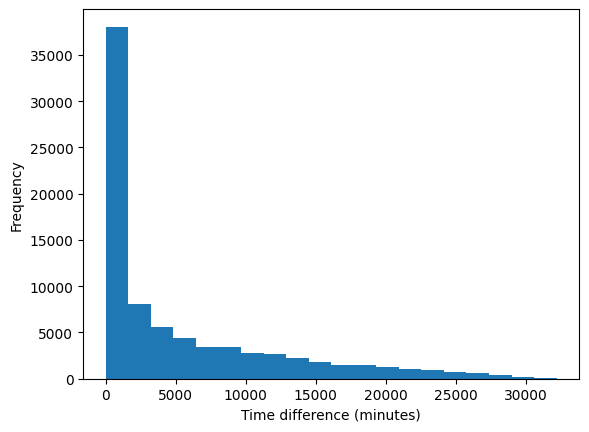

New threshold: 5412.605807846771 minutes
Feb


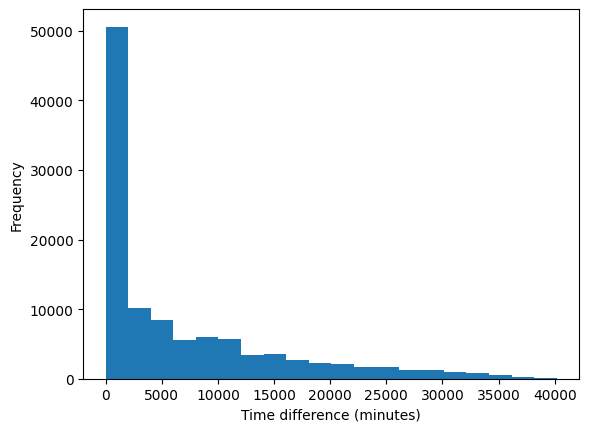

New threshold: 6687.114685314686 minutes
Mar


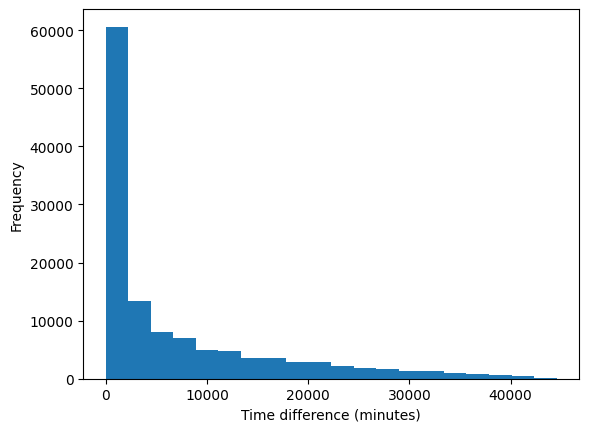

New threshold: 6915.018111475197 minutes
Apr


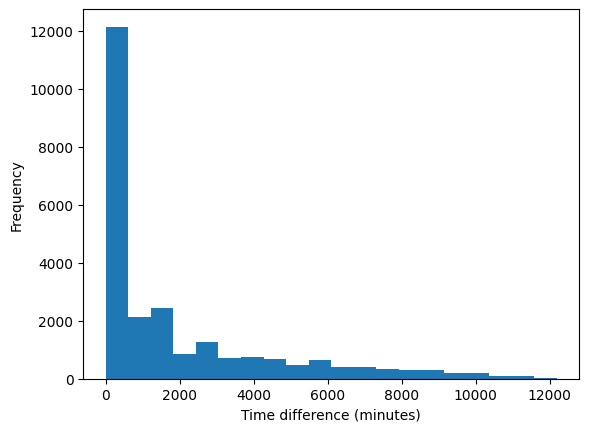

New threshold: 1905.3555283557732 minutes
average threshold: 5230.023533248107 minutes


In [ ]:
#This is the code to determine the threshold for influence, month wise, take average for every month, and take average of every average.
#--------------------------------------------------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


songs_df = pd.read_csv('quarterly_yeardata_track_data.csv')

#Empty array for storing the time differences
time_diffs = []

#Everyday Thresholds
thresholds = []

data2 = songs_df["date"].str.split(',', expand=True)
data7 = songs_df['date'].str.split(' ',expand=True)
data7.rename(columns = {0:'day', 1:'month', 2:'year',3:'time'}, inplace=True)
data5 = data7["time"].str.split(':', expand=True)
data5.rename(columns = {0:'hour',1:'minute'}, inplace=True)
data3=songs_df['username']
data4=songs_df['tracks']
data1=pd.concat([data3,data4,data5,data7], axis=1)
hashtable={1:'Jan',2:'Feb',3:'Mar',4:'Apr'}
# hashtable={1:'Jun',2:'Jul',3:'Aug',4:'Sep',5:'Oct',6:'Nov',7:'Dec'}

for i in range(1,len(hashtable)+1):
  string = str(hashtable[i]) 
  print(string)
  data = data1[data1.month == string]
  grouped_df = data.groupby('tracks')
  time_diffs=[]

  # Loop through each group and compare the timestamp of each user's listening event with their friend's listening event
  for song, group in grouped_df:
      user1 = None
      user2 = None
      for i, row in group.iterrows():
          if user1 is None:
              user1 = row
          elif user2 is None:
              user2 = row
          else:
              # Calculate the time difference between the two user's listening activity in days
              time_diff_days = abs((int(user1['hour']) - int(user2['hour']))*60 + (int(user1['minute']) - int(user2['minute'])) + (int(user1['day']) - int(user2['day']))*1440)
              time_diffs.append(time_diff_days)
              user1 = row
              user2 = None
  thresholds.append(np.mean(time_diffs))

  # Plot a histogram of the time differences
  plt.hist(time_diffs, bins=20)
  plt.xlabel('Time difference (minutes)')
  plt.ylabel('Frequency')
  plt.show()

  # Calculate the average time difference 
  new_threshold = np.mean(time_diffs)
  if(len(time_diffs)==0):
    continue
  else:
    thresholds.append(new_threshold)
  print(f'New threshold: {new_threshold} minutes')
avg_threshold = np.mean(thresholds)
print(f'average threshold: {avg_threshold} minutes')

# Conversion to csv of users and time differences

In [ ]:
#This is the code to make csv file for user1, user2 and time difference 
#-------------------------------------------------------------------------------

import csv

with open("quarter_year_edge_weight.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Source", "target","edge_attr"])

    for song, group in grouped_df:
        user1 = None
        user2 = None
        for i, row in group.iterrows():
            if user1 is None:
                user1 = row
            elif user2 is None:
                user2 = row
                if(user1['username']!=user2['username']):
                  print(user2)
                else:
                  user2=None
            else:
                time_diff_days = abs((int(user1['hour']) - int(user2['hour']))*60 + (int(user1['minute']) - int(user2['minute'])) + (int(user1['day']) - int(user2['day']))*1440)
                if(time_diff_days <= avg_threshold):
                  writer.writerow([user1['username'], user2['username'], time_diff_days])
                user1 = row
                user2 = None

Streaming output truncated to the last 5000 lines.
day               01
month            Apr
year           2021,
time           04:51
Name: 118520, dtype: object
username    Babs_05
tracks        Woman
hour             18
minute           04
day              06
month           Apr
year          2021,
time          18:04
Name: 348312, dtype: object
username    Amberface
tracks          Woman
hour               08
minute             13
day                08
month             Apr
year            2021,
time            08:13
Name: 518216, dtype: object
username    mussin
tracks       Woman
hour            10
minute          19
day             04
month          Apr
year         2021,
time         10:19
Name: 717147, dtype: object
username    1stepkloser
tracks            Woman
hour                 02
minute               31
day                  09
month               Apr
year              2021,
time              02:31
Name: 941430, dtype: object
username    Laurent_Olivier
tracks           

# Merging the time differences and edge weights

In [ ]:
# This is the code to merge the time diff with the friends file and give the edge weights
#----------------------------------------------------------------------------------------------

import pandas as pd

friends = pd.read_csv('friends_data.csv')
weight = pd.read_csv('quarter_year_edge_weight.csv')

# merge the two dataframes 
merged_df = pd.merge(friends, weight, left_on=['username', 'friend'], right_on=['Source', 'target'], how='left')

merged_df.fillna(0, inplace=True)

# adding new column named 'weight'
merged_df['weight'] = 0

# update the weight of the edge by 1 if the time difference is not 0
merged_df.loc[merged_df['edge_attr'] != 0, 'weight'] += 1

#Dropping unwanted columns
merged_df.drop(['Source','target','edge_attr'], axis="columns")

merged_df.to_csv('updated_friends.csv', index=False)






# Direct Influence

In [ ]:
# This is the code which calculates influence based on the sum of edge weights
#---------------------------------------------------------------------------------------

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import csv
df = pd.read_csv('updated_friends.csv')
# creating a directed graph
G = nx.DiGraph()

for i, row in df.iterrows():
    G.add_edge(row['Source'], row['target'], weight=row['edge_attr'])

#Storing the outdegree and sum of edge weight for each node
node_influence = {}

for node in G.nodes():
    out_degree = G.out_degree(node)
    neighbor_sum = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
    node_influence[node] = (neighbor_sum)

print(node_influence)

with open("wideness.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["user", "wide"])
    for i in node_influence:
      writer.writerow([i, node_influence[i]])

# data69 = pd.DataFrame(node_influence)
# data69_1 = data69.transpose()
# data69_1.rename(columns = {0:"out_degree",1:"neighbor_sum"}, inplace = True)
# data69_2=  data69.drop("out_degree",axis=1)
# print(data69_2)
# graph1=data69_2['neighbor_sum']

df1 = pd.read_csv('deepness.csv')
df2 = pd.read_csv('wideness.csv')

merged_df = pd.merge(df1, df2, on='user')

print(merged_df)

# # Save the merged data to a new CSV file
merged_df.to_csv('merged_file_di.csv', index=False)


# plt.hist(data69_2, bins=20)
# plt.xlabel('Direct Influence')
# plt.ylabel('Frequency')
# plt.show()


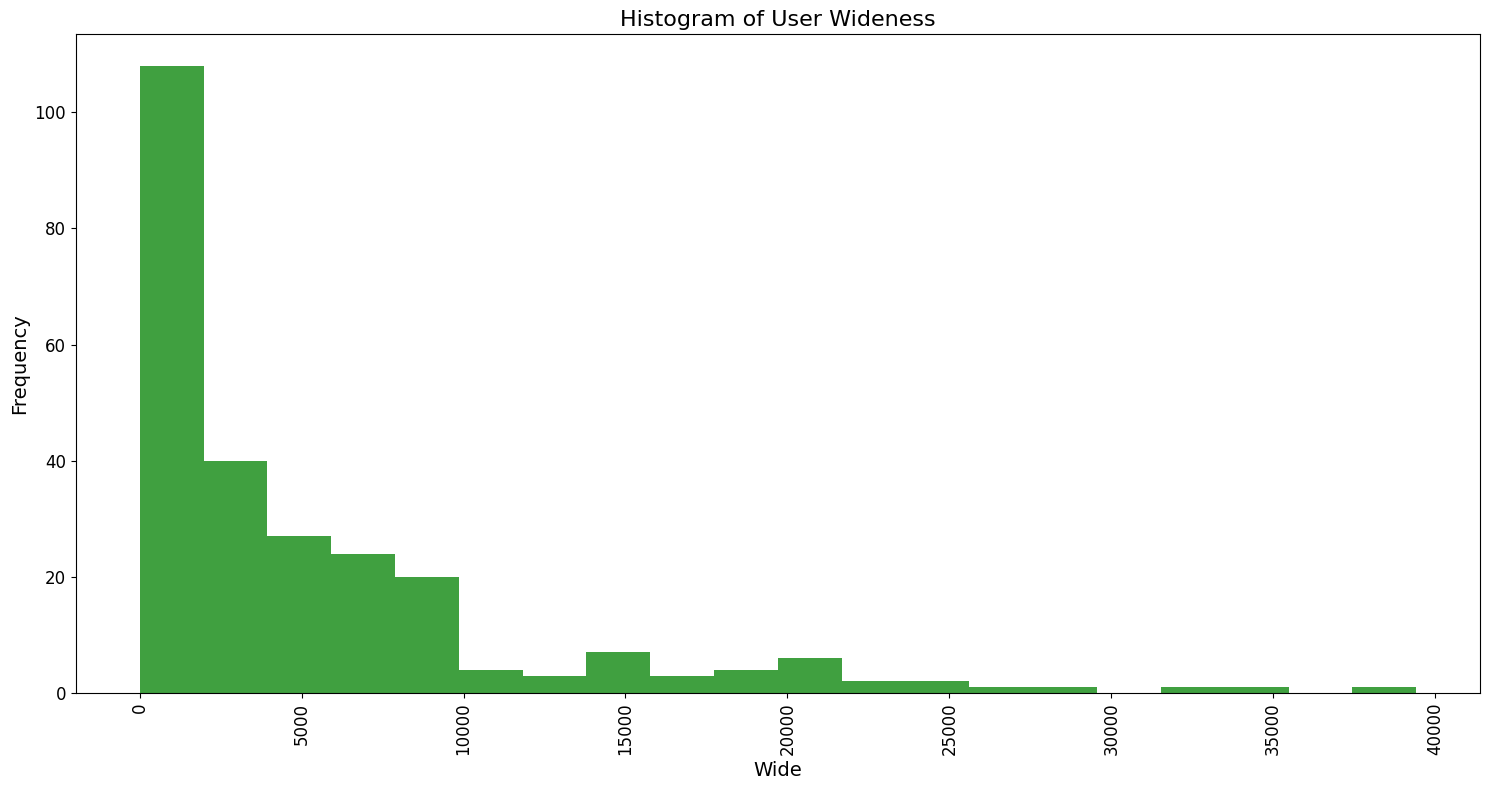

In [ ]:
df = pd.read_csv('wideness.csv')
plt.figure(figsize=(15, 8))
plt.hist(df['wide'], bins=20, color='g', alpha=0.75)
plt.xlabel('Wide', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of User Wideness', fontsize=16)
plt.tight_layout()
plt.show()

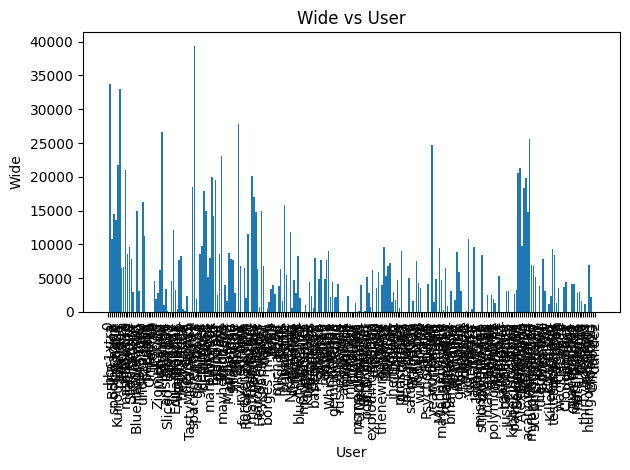

In [ ]:
plt.bar(range(len(df)), df['wide'])
plt.xticks(range(len(df)), df['user'], rotation=90)
plt.xlabel('User')
plt.ylabel('Wide')
plt.title('Wide vs User')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv('updated_friends.csv')

# creating a directed graph
G = nx.DiGraph()

for i, row in df.iterrows():
    G.add_edge(row['Source'], row['target'], weight=row['edge_attr'])

#Storing the outdegree and sum of edge weight for each node
node_influence = {}

for node in G.nodes():
    out_degree = G.out_degree(node)
    neighbor_sum = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
    node_influence[node] = (out_degree, neighbor_sum)

# Plotting the graph for each user
for node, influence in node_influence.items():
    plt.figure()
    plt.title('Influence for user {}'.format(node))
    plt.xlabel('Type of Influence')
    plt.ylabel('Magnitude')
    plt.bar('Neighbor Sum', influence[1])
    plt.show()


In [ ]:
#Plots for Direct Influence

# import matplotlib.pyplot as plt

# plt.figure()
# # plt.hist(data69_2, bins=50)
# plt.bar(data69_2['username'], data69_2['neighbor_sum'])
# plt.xlabel('Neighbour_sum')
# plt.ylabel('No. of Users')
# plt.title('Histogram of direct influence score of the users')
# plt.show()

# Indirect Influence

In [ ]:
#If you want to do analysis on deepness on the whole dataset

# import sys
# sys.setrecursionlimit(1000) # Set the recursion limit to a large number


In [ ]:
# This is the code to calculate indirect influence
#---------------------------------------------------------

import pandas as pd
import networkx as nx
import csv

df = pd.read_csv('updated_friends.csv')

G = nx.from_pandas_edgelist(df, source='username', target='friend', edge_attr='weight', create_using=nx.DiGraph())

graph = {}

with open('updated_friends (4).csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source = row['username']
        target = row['friend']
        weight = float(row['weight'])
        
        if source not in graph:
            graph[source] = []
        graph[source].append((target, weight))

def sum_of_all_paths(node, graph, depth):
    total_weight = 0
    
    # DFS function for traversing the graph
    def dfs(node, current_weight, current_depth):
        nonlocal total_weight

        # Determining the threshold of level of deepeness
        if current_depth > depth:
            return
        
        if node not in graph:
            return
        
        for neighbor, weight in graph[node]:
            total_weight += weight
            dfs(neighbor, current_weight + weight, current_depth + 1)

    # Starting the traversal from the specified node
    dfs(node, 0, 0)
    return total_weight

try:
    deepness_df = pd.read_csv('deepness.csv', index_col='node')
except FileNotFoundError:
    deepness_df = pd.DataFrame(columns=['node', 'depth_1', 'depth_2'])


new_data = []
for node in G.nodes():
    depth_1 = sum_of_all_paths(node, graph, 1)
    depth_2 = sum_of_all_paths(node, graph, 2)
    # depth_3 = sum_of_all_paths(node, graph, 3)
    # print(depth_3)
    new_data.append({'node': node, 'depth_1': depth_1, 'depth_2': depth_2})

    if node not in deepness_df.index:
        deepness_df.loc[node] = [node, depth_1, depth_2]

deepness_df.to_csv('deepness.csv', index=False)
print(deepness_df)

data = pd.DataFrame(node_influence)
data.rename(columns = {0:"user",1:"depth1", 2:'depth2', 3:'depth'}, inplace = True)
data=  data.drop("depth1",axis=1)
data = data.drop('depth2',axis=1)


                 depth_1  depth_2  depth_3
node                                      
tapenoon        tapenoon    190.0  22223.0
bbc1xtra        bbc1xtra    633.0  30971.0
BBCRadio3      BBCRadio3    255.0  22960.0
spookycharm  spookycharm    382.0  25179.0
L_Castle        L_Castle    193.0  22226.0
...                  ...      ...      ...
Flamingosis  Flamingosis      0.0      0.0
SyntaxE          SyntaxE      0.0      0.0
clairewkyb    clairewkyb     51.0   7946.0
Yllona            Yllona      8.0    543.0
cakemix          cakemix      2.0    492.0

[1408 rows x 3 columns]


In [ ]:
data = pd.DataFrame(deepness_df)
data.rename(columns = {0:"user",1:"depth1", 2:'depth2', 3:'depth'}, inplace = True)
print(data)
data=  data.drop("depth1")
data = data.drop('depth2')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
print(deepness_df)
deepness_df = pd.read_csv('deepness.csv')




# Plot the data for each depth level
for i in range(1, 3):
    plt.figure()
    plt.title('Depth {}'.format(i))
    plt.xlabel('User')
    plt.ylabel('Number of Influences')
    plt.bar(deepness_df['node'], deepness_df['depth_{}'.format(i)])
    plt.xticks(rotation=90)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Load the deepness data
deepness_df = pd.read_csv('deepness.csv')

# Define the nodes to plot
nodes = list(deepness_df['node'])

# Define the depths to plot
depths = ['depth_1', 'depth_2']

# Plot per user graphs for each depth
for depth in depths:
    for node in nodes:
        node_df = deepness_df[deepness_df['node'] == node]
        x = node_df[depth].values[0]
        y = node_df.index.values[0]
        plt.barh(y, x)
        plt.title(f'{node} Influence at {depth}')
        plt.xlabel('Total Weight')
        plt.ylabel('User')
    plt.show()


{'depth_1': 0.0       84
2.0       46
3.0       45
4.0       76
5.0       49
          ..
1478.0     1
1503.0     1
1549.0     1
1585.0     1
3070.0     1
Name: depth_1, Length: 259, dtype: int64, 'depth_2': 0.0         84
492.0       46
493.0        2
543.0       44
544.0        1
            ..
233439.0     1
243589.0     1
266881.0     1
267258.0     1
301709.0     1
Name: depth_2, Length: 339, dtype: int64}


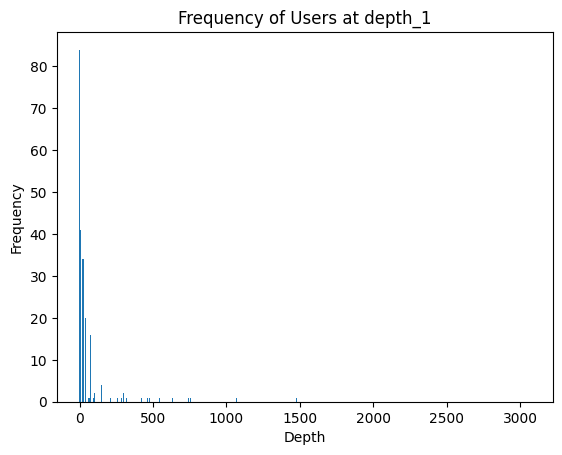

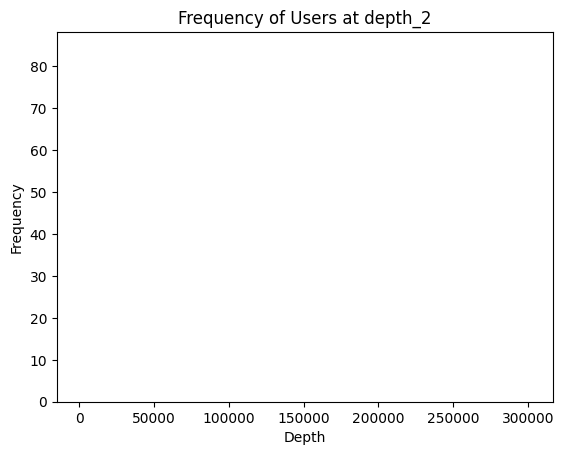

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the deepness data
deepness_df = pd.read_csv('deepness.csv')

# Define the depths to plot
depths = ['depth_1', 'depth_2']

# Calculate frequency of users for each depth
depth_freq = {}
for depth in depths:
    depth_freq[depth] = deepness_df[depth].value_counts().sort_index()
print(depth_freq)
# Plot bar graphs for each depth
for depth in depths:
    plt.bar(depth_freq[depth].index, depth_freq[depth].values)
    plt.title(f'Frequency of Users at {depth}')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('deepness.csv')

plt.bar(df1, depth_freq[depth].values)
    plt.title(f'Frequency of Users at {depth}')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import csv
import matplotlib.pyplot as plt

df = pd.read_csv('updated_friends.csv')

G = nx.from_pandas_edgelist(df, source='username', target='friend', edge_attr='weight', create_using=nx.DiGraph())

graph = {}

with open('updated_friends.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source = row['username']
        target = row['friend']
        weight = float(row['weight'])
        
        if source not in graph:
            graph[source] = []
        graph[source].append((target, weight))

def sum_of_all_paths(node, graph, depth):
    total_weight = 0
    
    # DFS function for traversing the graph
    def dfs(node, current_weight, current_depth):
        nonlocal total_weight

        # Determining the threshold of level of deepeness
        if current_depth > depth:
            return
        
        if node not in graph:
            return
        
        for neighbor, weight in graph[node]:
            total_weight += weight
            dfs(neighbor, current_weight + weight, current_depth + 1)

    # Starting the traversal from the specified node
    dfs(node, 0, 0)
    return total_weight

try:
    deepness_df = pd.read_csv('deepness.csv', index_col='node')
except FileNotFoundError:
    deepness_df = pd.DataFrame(columns=['node', 'depth_1', 'depth_2', 'depth_3'])


for node in G.nodes():
    depth_1 = sum_of_all_paths(node, graph, 1)
    depth_2 = sum_of_all_paths(node, graph, 2)
    # depth_3 = sum_of_all_paths(node, graph, 3)
    # print(depth_1)
    # print(depth_2)
    # print(depth_3)

    # Plotting individual graphs
    fig, ax = plt.subplots()
    ax.bar(['Depth 1', 'Depth 2'], [depth_1, depth_2])
    ax.set_title(node)
    plt.savefig(f'{node}.png')
    plt.close()

    # Updating deepness dataframe
    if node not in deepness_df.index:
        deepness_df.loc[node] = [node, depth_1, depth_2]

# Plotting combined graph with bars for depth1 and depth2 of all users
fig, ax = plt.subplots()
width = 0.35
ax.bar(deepness_df.index - width/2, deepness_df['depth_1'], width, label='Depth 1')
ax.bar(deepness_df.index + width/2, deepness_df['depth_2'], width, label='Depth 2')
ax.set_xticks(deepness_df.index)
ax.set_xticklabels(deepness_df.index)
ax.legend()
plt.savefig('all_users.png')
plt.show()

deepness_df.to_csv('deepness.csv', index=False)
# print(deepness_df)


In [ ]:
import pandas as pd
import networkx as nx
import csv
import matplotlib.pyplot as plt

df = pd.read_csv('updated_friends.csv')

G = nx.from_pandas_edgelist(df, source='username', target='friend', edge_attr='weight', create_using=nx.DiGraph())

graph = {}

with open('updated_friends.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        source = row['username']
        target = row['friend']
        weight = float(row['weight'])
        
        if source not in graph:
            graph[source] = []
        graph[source].append((target, weight))

def sum_of_all_paths(node, graph, depth):
    total_weight = 0
    
    # DFS function for traversing the graph
    def dfs(node, current_weight, current_depth):
        nonlocal total_weight

        # Determining the threshold of level of deepness
        if current_depth > depth:
            return
        
        if node not in graph:
            return
        
        for neighbor, weight in graph[node]:
            total_weight += weight
            dfs(neighbor, current_weight + weight, current_depth + 1)

    # Starting the traversal from the specified node
    dfs(node, 0, 0)
    return total_weight

try:
    deepness_df = pd.read_csv('deepness.csv', index_col='node')
except FileNotFoundError:
    deepness_df = pd.DataFrame(columns=['node', 'depth_1', 'depth_2', 'depth_3'])


for node in G.nodes():
    depth_1 = sum_of_all_paths(node, graph, 1)
    depth_2 = sum_of_all_paths(node, graph, 2)
    # depth_3 = sum_of_all_paths(node, graph, 3)
    # print(depth_1)
    # print(depth_2)
    # print(depth_3)

    # Plotting individual graphs
    fig, ax = plt.subplots()
    ax.bar(['Depth 1', 'Depth 2'], [depth_1, depth_2])
    ax.set_title(node)
    plt.show()
    plt.close()

    # Updating deepness dataframe
    if node not in deepness_df.index:
        deepness_df.loc[node] = [node, depth_1, depth_2]

# Plotting combined graph with bars for depth1 and depth2 of all users
fig, ax = plt.subplots()
width = 0.35
ax.bar(deepness_df.index - width/2, deepness_df['depth_1'], width, label='Depth 1')
ax.bar(deepness_df.index + width/2, deepness_df['depth_2'], width, label='Depth 2')
ax.set_xticks(deepness_df.index)
ax.set_xticklabels(deepness_df.index)
ax.legend()
plt.show()

deepness_df.to_csv('deepness.csv', index=False)
# print(deepness_df)


In [ ]:
# This is the code to calculate indirect influence for depth = 3
#---------------------------------------------------------

# import pandas as pd
# import networkx as nx
# import csv

# df = pd.read_csv('updated_friends.csv')

# G = nx.from_pandas_edgelist(df, source='username', target='friend', edge_attr='weight', create_using=nx.DiGraph())

# graph = {}

# with open('updated_friends.csv', newline='') as csvfile:
#     reader = csv.DictReader(csvfile)
#     for row in reader:
#         source = row['username']
#         target = row['friend']
#         weight = float(row['weight'])
        
#         if source not in graph:
#             graph[source] = []
#         graph[source].append((target, weight))

# def sum_of_all_paths(node, graph, depth):
#     total_weight = 0
    
#     # DFS function for traversing the graph
#     def dfs(node, current_weight, current_depth):
#         nonlocal total_weight

#         # Determining the threshold of level of deepeness
#         if current_depth > depth:
#             return
        
#         if node not in graph:
#             return
        
#         for neighbor, weight in graph[node]:
#             total_weight += weight
#             dfs(neighbor, current_weight + weight, current_depth + 1)

#     # Starting the traversal from the root node
#     dfs(node, 0, 0)
#     return total_weight

# try:
#     deepness_df = pd.read_csv('deepness_depth3.csv', index_col='node')
# except FileNotFoundError:
#     deepness_df = pd.DataFrame(columns=['node', 'depth_1', 'depth_2', 'depth_3'])


# new_data = []
# for node in G.nodes():
#     depth_1 = sum_of_all_paths(node, graph, 1)
#     depth_2 = sum_of_all_paths(node, graph, 2)
#     depth_3 = sum_of_all_paths(node, graph, 3)
#     print(depth_1)
#     print(depth_2)
#     print(depth_3)
#     new_data.append({'node': node, 'depth_1': depth_1, 'depth_2': depth_2, 'depth_3' : depth_3})

#     if node not in deepness_df.index:
#         deepness_df.loc[node] = [node, depth_1, depth_2, depth_3]

# deepness_df.to_csv('deepness_depth3.csv', index=False)
# print(deepness_df)


# Structural Holes

In [ ]:
#This is the code to find the structural holes in the network
#-----------------------------------------------------------------

import networkx as nx
import pandas as pd

filename = "quarter_year_edge_weight.csv"
try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print(f"{filename} not found. Please provide a valid filename.")
    exit()

try:
    G = nx.from_pandas_edgelist(df, source="Source", target="target", edge_attr="edge_attr")
except nx.NetworkXError:
    print("Failed to create graph from csv file. Check if the columns 'source', 'target', and 'weight' are present.")
    exit()

#Finding the structural hole
scores = nx.constraint(G)
score_arr = []

print(scores)

with open("structural_holes.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["user", "structural_hole"])
    for i in scores:
      writer.writerow([i, scores[i]])

df1 = pd.read_csv('deepness.csv')
df2 = pd.read_csv('wideness.csv')
df3 = pd.read_csv('structural_holes.csv')
merged_df = pd.merge(df1, df3, on='user')
merged_df2 = pd.merge(df2, df3, on='user')
print(merged_df)
print(merged_df2)
# # Save the merged data to a new CSV file
merged_df.to_csv('merged_file_is.csv', index=False)
merged_df2.to_csv('merged_file_ds.csv', index=False)
# for node, score in scores.items():
    # if(score<=1.0):
    #     score_arr.append(score)
    #     print(f"Node {node}: Structural Hole Score {score}")
# score_arr.sort()

quarter_year_edge_weight.csv not found. Please provide a valid filename.
{'0': 4.0, 'bbc1xtra': 0.18244153534691188, 'BBCRadio3': 0.27098661948967895, 'spookycharm': 0.190931279220542, 'L_Castle': 0.31426925536815653, 'KuriousBanana': 0.1804728421770616, 'raffy_rillo': 0.1644238753807619, 'snyde1': 0.21154678254437873, 'juepucta': 0.21694140032738934, 'massdosage': 0.1334761174140545, 'jamesxoxo': 0.2577803203728792, 'acreature': 0.22261804129935997, 'Sliders1234': 0.1908486540858622, 'flaneur': 0.1586753619325904, 'spookydirt': 0.6302186061801447, 'BlueHeronRadio': 0.20849572456956772, 'LAST.HQ': 0.5, 'TheMannen': 1.0, 'underpangs': 0.12007019493297541, 'nrth': 0.17476002629848778, 'pecusita': 0.5721673909023668, 'caitlin': 0.5986328125, 'Omar711': 0.5721673909023668, 'Tecfan': 0.25443694526627225, 'Troegie': 0.2699704142011834, 'RJ': 0.5, 'Ziomek2000': 0.6063470784023668, 'bhavnit': 0.33188633786848076, 'IM4ttthew': 0.16484552154195012, 'kuzronk': 0.3220649092970521, 'aristotle137': 

In [ ]:
print(score_arr)

[0.020842005105228406, 0.021326476855274116, 0.02173537142108209, 0.02188933816308684, 0.02609741437195317, 0.02629929815197209, 0.026389609773584833, 0.026766912812071025, 0.027444500663032965, 0.028112442552568277, 0.02922890225144685, 0.02947483859973233, 0.029739846368462983, 0.029960804362646122, 0.030458009261599014, 0.030666043677931333, 0.030774486206239515, 0.030829373557094444, 0.03135485706280544, 0.03202889930909477, 0.03225302081878214, 0.03251291434240542, 0.0325176557483812, 0.03301359709929547, 0.03364189853707056, 0.03370656645863721, 0.03390313406039625, 0.034078122397789554, 0.03418303561051266, 0.03459622783499807, 0.03481111885284811, 0.03544798960041631, 0.03551269802286708, 0.03562282410711732, 0.035749784031279215, 0.03577820700200209, 0.03582209171838402, 0.03663963383266552, 0.0366423881367402, 0.037150039382695385, 0.038273157821092633, 0.03849317661824966, 0.03859310461075405, 0.038988209351101984, 0.039325863064848504, 0.03968927815705113, 0.039724383564314

In [ ]:
import numpy as np

# calculating the mean and standard deviation 
mean_score = np.sum(score_arr) / len(score_arr)
std_score = (sum((x - mean_score) * 2 for x in score_arr) / len(score_arr)) * 0.5

# setting the threshold as a multiple of the standard deviation above the mean
threshold = mean_score + 2 * std_score

print("Mean score: ", mean_score)
print("Standard deviation: ", std_score)
print("Threshold: ", threshold)

Mean score:  0.16060571486728348
Standard deviation:  -1.1991726438087744e-16
Threshold:  0.16060571486728323


In [ ]:
ab_threshold = []
for score in score_arr:
  if(score>=threshold):
    ab_threshold.append(score)

print(ab_threshold)

[0.16387196889138075, 0.16666666666666669, 0.1687487991061497, 0.16903635534737882, 0.17095571257377062, 0.1742580421821628, 0.17448608634256252, 0.17586695124362747, 0.17807168110357102, 0.18063867562585734, 0.18161315405700948, 0.1851503994527897, 0.18677727508840775, 0.19335228562023676, 0.20000000000000004, 0.20288805728679216, 0.20292585591262344, 0.20349340079150438, 0.2038827421552015, 0.20411087968174646, 0.20498574380442516, 0.2050210559399808, 0.20646203850160108, 0.2065720702523854, 0.20978519684056524, 0.21077595294316076, 0.21085048464442405, 0.21154678254437873, 0.21356666531959778, 0.2192070936639119, 0.2357650556894922, 0.23772588131030614, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25460943936601166, 0.25947312043709736, 0.2632051200463362, 0.28368962407700027, 0.28752638678899195, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.33836471336513524, 0.3428713677689669, 0.34960565007351396, 0.35244035558999975, 0.3619479773905277, 0.3632004490400194

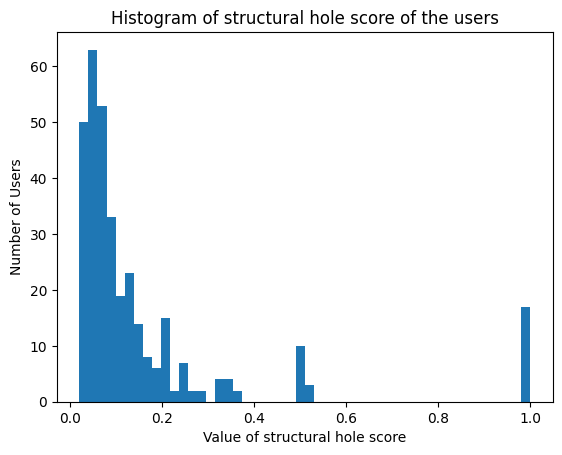

In [ ]:
import matplotlib.pyplot as plt

#plots
plt.hist(score_arr, bins=50)
plt.xlabel('Value of structural hole score')
plt.ylabel('Number of Users')
plt.title('Histogram of structural hole score of the users')
plt.show()

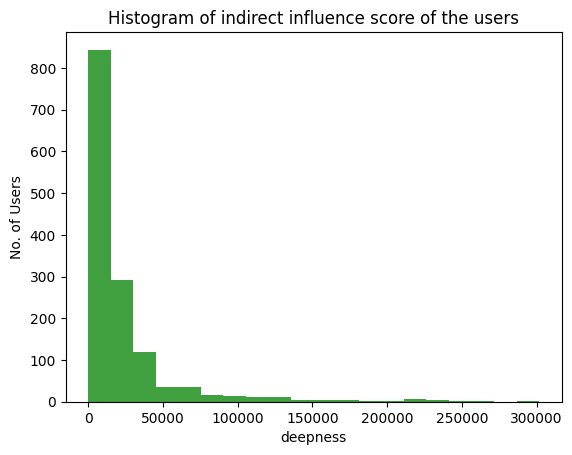

In [ ]:
import matplotlib.pyplot as plt

df1 = pd.read_csv('deepness.csv')

plt.figure()
# plt.hist(data69_2, bins=50)
plt.hist(df1['depth'], bins=20, color='g', alpha=0.75)
# plt.bar(df1['user'], df1['depth'])
plt.xlabel('deepness')
plt.ylabel('No. of Users')
plt.title('Histogram of indirect influence score of the users')
plt.show()


# Betweeeness Centrality


In [ ]:
import csv
import networkx as nx

# calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight="weight")

# calculate number of triangles each node belongs to
triangles = nx.triangles(G)

max_bwtncentr = max(betweenness_centrality.items(), key=lambda x: x[1])

# Print the maximum betweenness centrality value and node
print("Maximum betweenness centrality value: ", max_bwtncentr[1])
print("Node with maximum betweenness centrality: ", max_bwtncentr[0])

# write the results to a CSV file
with open('betweenness_centrality.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['username', 'betweenness_centrality', 'triangles'])
    for node in G.nodes():
        writer.writerow([node, betweenness_centrality[node], triangles[node]])


Maximum betweenness centrality value:  0.09739080338976203
Node with maximum betweenness centrality:  IM4ttthew


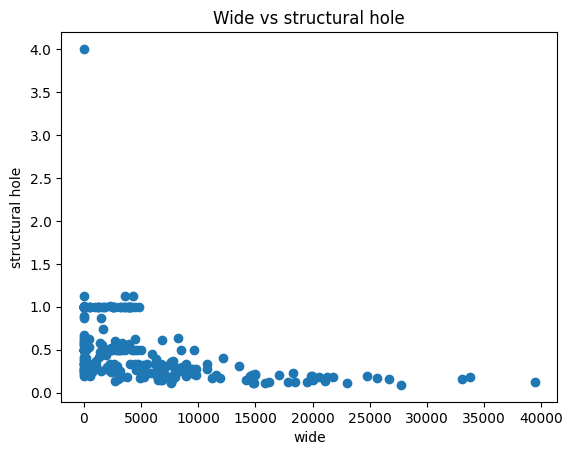

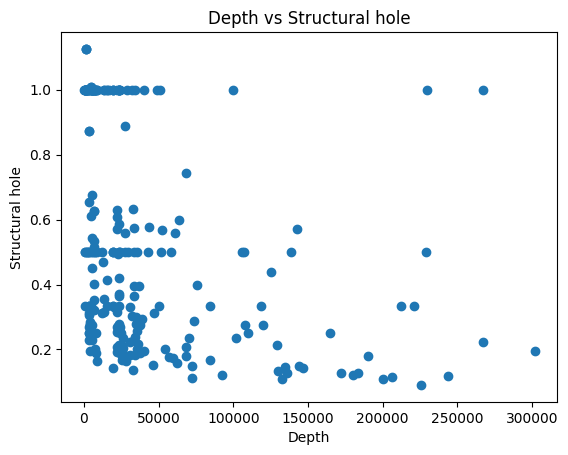

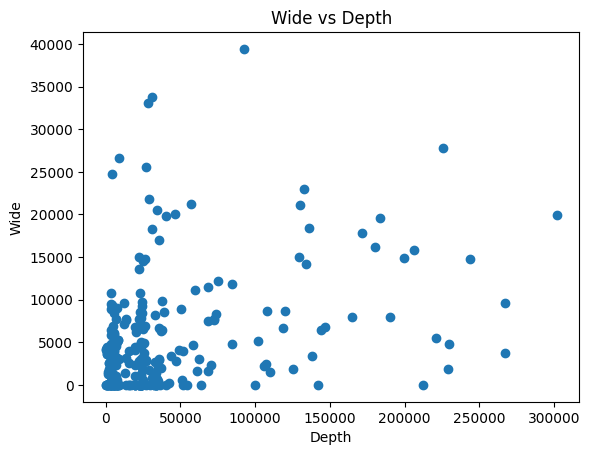

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df1=pd.read_csv('merged_file_di.csv')
df2=pd.read_csv('merged_file_ds.csv')
df3=pd.read_csv('merged_file_is.csv')

# Extract 'wide' and 'depth' columns
wide = df1['wide']
depth = df1['depth']

wide1 = df2['wide']
sthole = df2['structural_hole']

depth1 = df3['depth']
sthole1 = df3['structural_hole']

# Create a scatter plot
plt.scatter(wide1, sthole)
plt.xlabel('wide')
plt.ylabel('structural hole')
plt.title('Wide vs structural hole')
plt.show()

# Create a scatter plot
plt.scatter(depth1, sthole1)
plt.xlabel('Depth')
plt.ylabel('Structural hole')
plt.title('Depth vs Structural hole')
plt.show()

# Create a scatter plot
plt.scatter(depth, wide)
plt.xlabel('Depth')
plt.ylabel('Wide')
plt.title('Wide vs Depth')
plt.show()